# <font color='teal'> Introduction to Neural Networks and Pytorch </font>

    Notebook version: 0.2. (Nov 5, 2021)

    Authors: Jerónimo Arenas García (jarenas@ing.uc3m.es)
             Jesús Cid-Sueiro (jcid@tsc.uc3m.es)

    Changes: v.0.1. (Nov 14, 2020) - First version
             v.0.2. (Nov 5, 2021) - Structuring code, revisiting formulation
             v.0.3. (Nov, 1, 2022) - Revisiting text.
    
    Pending changes:
        Use epochs instead of iters in first part of notebook
        Add an example with dropout
        Add theory about CNNs
        Define some functions to simplify code cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

size = 14
params = {'legend.fontsize': 'Large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

## <font color='teal'> 1. Introduction and purpose of this Notebook </font>

### <font color='teal'> 1.1. About Neural Networks </font>

* Neural Networks (NN) have become the state of the art for many machine learning problems
    * Natural Language Processing
    * Computer Vision
    * Image Recognition


* They are in widespread use for many applications, e.g.,
    * Language translation (<a href="https://arxiv.org/pdf/1609.08144.pdf">Google Neural Machine Translation System</a>) 
    * Automatic speech recognition (<a href="https://machinelearning.apple.com/research/hey-siri">Hey Siri!</a> DNN overview)
    * Autonomous navigation (<a href="https://venturebeat.com/2020/04/13/facebooks-ai-teaches-robots-to-navigate-environments-using-less-data/">Facebook Robot Autonomous 3D Navigation</a>)
    * Automatic plate recognition
    
<center><img src="figures/ComputerVision.png" /></center>
    

Feed Forward Neural Networks [have been around since 1960](https://www.skynettoday.com/overviews/neural-net-history) but only recently (last 10-12 years) have they met their expectations, and improve other machine learning algorithms

* Computation resources are now available at large scale
* Cloud Computing (AWS, Azure)
* From MultiLayer Perceptrons to Deep Learning
* Big Data sets
* This has also made possible an intense research effort resulting in
    * Topologies better suited to particular problems (CNNs, RNNs)
    * New training strategies providing better generalization

In parallel, Deep Learning Platforms have emerged that make design, implementation, training, and production of DNNs feasible for everyone

### <font color='teal'> 1.2. Scope</font>

* To provide just an overview of most important NNs and DNNs concepts
* Connecting with already studied methods as starting point
* Introduction to PyTorch
* Providing links to external sources for further study

### <font color='teal'> 1.3. Outline</font>

1. Introduction and purpose of this Notebook
2. Introduction to Neural Networks
3. Implementing Deep Networks with PyTorch

### <font color='teal'> 1.4. Other resources </font>

* We point here to external resources and tutorials that are excellent material for further study of the topic
* Most of them include examples and exercises using numpy and PyTorch
* This notebook uses examples and other material from some of these sources

|Tutorial|Description|
|-----|---------------------|
|<a href="https://www.simplilearn.com/tutorials/deep-learning-tutorial"> <img src="figures/simplilearn.png" width="100"/> </a>|Very general tutorial including videos and an overview of top deep learning platforms|
|<a href="http://d2l.ai/"> <img src="figures/dl2ai.png" width="100"/> </a>|Very complete book with a lot of theory and examples for MxNET, PyTorch, and TensorFlow|
|<a href="https://pytorch.org/tutorials/"> <img src="figures/PyTorch.png" width="100"/> </a>|Official tutorials from the PyTorch project. Contains a 60 min overview, and a very practical *learning PyTorch with examples* tutorial|
|<a href="https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners"> <img src="figures/kaggle.png" width="100"/> </a>|Kaggle tutorials covering an introduction to Neural Networks using Numpy, and a second one offering a PyTorch tutorial|

In addition to this, PyTorch MOOCs can be followed for free in main sites: edX, Coursera, Udacity

## <font color='teal'> 2. Datasets </font>

Along this notebook, we will run some experiments to solve classification problems using two image datasets, that we name "digits" and "DogCats"


### <font color='olive'>Digits: a sign language digits data set</font>

* Dataset is taken from <a href="https://www.kaggle.com/ardamavi/sign-language-digits-dataset"> Kaggle</a> and used in the above referred tutorial
* 2062 digits in sign language. $64 \times 64$ images
* Problem with 10 classes. One hot encoding for the label matrix
* Input data are images, we create also a flattened version

Size of Input Data Matrix: (2062, 64, 64)
Size of Flattned Input Data Matrix: (2062, 4096)
Size of label Data Matrix: (2062, 10)


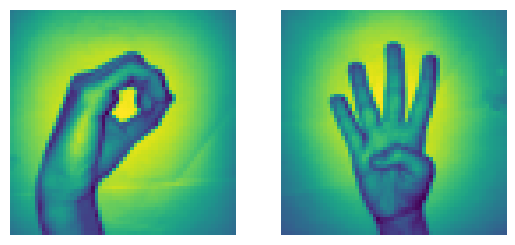

Labels corresponding to figures: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [2]:
# Load images and labels
digitsX = np.load('./data/Sign-language-digits-dataset/X.npy')
digitsY = np.load('./data/Sign-language-digits-dataset/Y.npy')

# Flatten images (to get 1-dimensional inputs
K = digitsX.shape[0]
img_size = digitsX.shape[1]
digitsX_flatten = digitsX.reshape(K,img_size*img_size)

print('Size of Input Data Matrix:', digitsX.shape)
print('Size of Flattned Input Data Matrix:', digitsX_flatten.shape)
print('Size of label Data Matrix:', digitsY.shape)

# Show sample images
selected = [260, 1400]
plt.subplot(1, 2, 1), plt.imshow(digitsX[selected[0]].reshape(img_size, img_size)), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(digitsX[selected[1]].reshape(img_size, img_size)), plt.axis('off')
plt.show()
print('Labels corresponding to figures:', digitsY[selected,])

### <font color='olive'> DogCats: a dataset of dogs and cat images </font>

* Dataset is taken from <a href="https://www.kaggle.com/c/dogs-vs-cats"> Kaggle</a>
* 25000 pictures of dogs and cats
* Binary problem
* Input data are images, we create also a flattened version
* Original images are RGB, and arbitrary size
* Preprocessed images are $64 \times 64$ and gray scale

In [3]:
# Preprocessing of original Dogs and Cats Pictures
# Adapted from 
# https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1
# RGB channels are collapsed in GRAYSCALE
# Images are resampled to 64x64
# This code has been used to generate the adapted dataset used in this notebook, that is stored in 
# ./data/DogsCats/ . 
# You can uncomment this code to re-generate the dataset, if needed.
"""
import os, cv2  # cv2 -- OpenCV

train_dir = './data/DogsCats/train/'
rows, cols = 64, 64
train_images = sorted([train_dir+i for i in os.listdir(train_dir)])

def read_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(image, (rows, cols),interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    m = len(images)
    X = np.ndarray((m, rows, cols), dtype=np.uint8)
    y = np.zeros((m,))
    print("X.shape is {}".format(X.shape))
  
    for i,image_file in enumerate(images) :
        image = read_image(image_file)
        X[i,] = np.squeeze(image.reshape((rows, cols)))
        if 'dog' in image_file.split('/')[-1].lower():
            y[i] = 1
        elif 'cat' in image_file.split('/')[-1].lower():
            y[i] = 0
      
        if i%5000 == 0 :
            print(f"Proceed {i} of {m}")
    
    return X,y

X_train, y_train = prep_data(train_images)
np.save(X.npy', X_train)
np.save('./data/DogsCats/Y.npy', y_train)
"""
None

Size of Input Data Matrix: (25000, 64, 64)
Size of Flattned Input Data Matrix: (25000, 4096)
Size of label Data Matrix: (25000,)


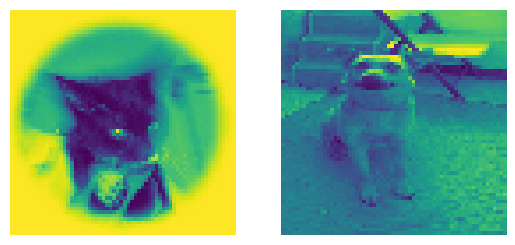

Labels corresponding to figures: [0. 1.]


In [4]:
# Load images and labels
DogsCatsX = np.load('./data/DogsCats/X.npy')
DogsCatsY = np.load('./data/DogsCats/Y.npy')

# Flatten images to get 1D inputs
K = DogsCatsX.shape[0]
img_size = DogsCatsX.shape[1]
DogsCatsX_flatten = DogsCatsX.reshape(K,img_size*img_size)

print('Size of Input Data Matrix:', DogsCatsX.shape)
print('Size of Flattned Input Data Matrix:', DogsCatsX_flatten.shape)
print('Size of label Data Matrix:', DogsCatsY.shape)

# Show sample images
selected = [260, 16000]
plt.subplot(1, 2, 1), plt.imshow(DogsCatsX[selected[0]].reshape(img_size, img_size)), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(DogsCatsX[selected[1]].reshape(img_size, img_size)), plt.axis('off')
plt.show()
print('Labels corresponding to figures:', DogsCatsY[selected,])

Now we define a function that, given the dataset name, prepares the data for binary or multiclass classification. The data are normalized and split into two sets for training and validation. This method will be used later to select the appropriate datasets

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def get_dataset(dataset_name, forze_binary=False):
    """
    Loads the selected dataset, among two options: DogsCats or digits.
    
    If dataset_name == 'digits', you can take a dataset with two classes only,
    using forze_binary == True
    """

    if dataset_name == 'DogsCats':
        X = DogsCatsX_flatten
        y = DogsCatsY
    elif dataset_name == 'digits':
        if forze_binary:
            # Zero and Ones are one hot encoded in columns 1 and 4
            X0 = digitsX_flatten[np.argmax(digitsY, axis=1)==1,]
            X1 = digitsX_flatten[np.argmax(digitsY, axis=1)==4,]
            X = np.vstack((X0, X1))
            y = np.zeros(X.shape[0])
            y[X0.shape[0]:] = 1
        else:
            X = digitsX_flatten
            y = digitsY
    else:
        print("-- ERROR: Unknown dataset")
        return
    
    # Joint normalization of all data. For images [-.5, .5] scaling is frequent
    min_max_scaler = MinMaxScaler(feature_range=(-.5, .5))
    X = min_max_scaler.fit_transform(X)

    # Generate train and validation data, shuffle
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    return X_train, X_val, y_train, y_val

## <font color='teal'> 3. Introduction to Neural Networks </font>

In this section, we will implement neural networks from scratch using Numpy arrays

* No need to learn any new Python libraries
* But we need to deal with complexity of multilayer networks
* Low-level implementation will be useful to grasp the most important concepts concerning DNNs
    * Back-propagation
    * Activation functions
    * Loss functions
    * Optimization methods
    * Generalization
    * Special layers and configurations

### <font color='teal'> 3.1. A Single-Layer Neural Network for binary classification</font>

#### <font color='teal'> 3.1.1. Architecture </font>

One of the simplest neural network architectures for binary classification is shown in the figure

<center><img src="figures/LR_network.png" width="450"/></center>

The main components are:

 *  A **linear combination** of the input features is computed to produce the intermediate output
$$
o = {\bf w}^\intercal {\bf x} + b
$$
 * An **activation function**, which maps the linear combination to values in a bounded range, to produce the *soft* prediction
$$
q = g(o)
$$
A common choice for binary classification is the logistic function, which provides probabilistic predictions $q\in [0, 1]$,
$$
q = \text{logistic}(o) = \frac{1}{1 + \exp(-o)}.
$$
However, other activation functions are possible.
 * A **binary threshold**, transforming the *soft* prediction into a *hard* decision (the class prediction) in $\{0, 1\}$. Following the probabilistic interpretation of the soft prediction, a common choice is to apply a threshold $\frac12$, so that
$$
\hat{y} = \left[
    \begin{array}{ll}
    1, &  \text{if } q \ge \frac12   \\
    0, &  \text{if } q < \frac12
    \end{array} \right.
$$

We will define a ${\tt forward}$ method to implement the computation of the soft prediction, $q$. To do so, we define a method to implement the logistit function, too.

In [6]:
# Define some useful functions
def logistic(t):
    """ 
    Computes the logistic function
    """
    return 1.0 / (1 + np.exp(-t))

def forward(w,b,x):
    """
    Computes the network output
    """
    # return logistic(x.dot(w) + b)
    return logistic(x @ w + b)

For binary classification, our goal is to fit the weights so that the hard predictions are correct. Thererfore, a natural measure of the classification performance is the accuracy, defined as the average number of correct decisions.

In [7]:
def accuracy(y, q):
    return np.mean(y == (q >= 0.5))

#### <font color='teal'> 3.1.2. Loss functions </font>

The accuracy is a good measure for the evaluation of the classifiers, but it is not useful to define the learning algorithm. This is because learning algorithms for neural networs are mostly based on gradient-based optimization techniques. The thresholding function is not differentiable at $\frac{1}{2}$ and its derivative is zero elsewhere. Therefore, the derivatives of the accuracy with respect to the weights are not useful to guide learning.

For this reason, we need a **loss function**, that is, a measure of discrepancy between the true class, $y$, and the soft prediction $q$,
$$
\ell(y, q)
$$
that could be used for training. A basic learning algorithm will try to minimize the **empirical risk**, defined as cumulative loss over the whole training set
$$
R({\bf w}, b) = \sum_{k=0}^{K-1} \ell(y_k, q_k)
$$

Many losses have been proposed for neural networks. Some examples are:
* **Square error**: $\ell_2(y, q) = (y-q)^2$
* **Absolute error**: $\ell_1(y, q) = |y - q|$
* **Cross entropy**: $\ell_\text{CE}(y, q) = - y \log(q) - (1-y) \log(1-q)$

For binary classification, cross entroy is the most common choice.

#### <font color='teal'> 3.1.3. Logistic Regression vs Single Layer NN</font>

Any neural network with probabilistic soft decisions defines a parametric probability model of the data. For the single-layer NN, the parametric model will be
$$
P(y=1|{\bf w}, b, {\bf x}) = g({\bf w}^\intercal {\bf x} + b)
$$

Therefore, we can train a neural network following a probabilistic approach. For instance, the negative log likelihood will be given by 
\begin{align}
\text{NLL}({\bf w}, b) &= - \sum_{k=0}^{K-1} \log(P(y_k|{\bf w}, b, {\bf x}))    \\
    &= - \sum_{k=0}^{K-1} \left(y_k \log(P(1|{\bf w}, b, {\bf x})) + (1-y_k) \log( P(0|{\bf w}, b, {\bf x})) \right)  \\
    &= - \sum_{k=0}^{K-1} \left(y_k \log(q_k) + (1-y_k) \log(1-q_k) \right)   \\
    &= \sum_{k=0}^{K-1} \ell_\text{CE}(y_k, q_k)
\end{align}
which shows that the empirical risk of the cross entropy is the NLL and, thus, optimizing the cross entropy provides ML estimates of the weights. 

This also shows that a single-layer NN with logistic activation and cross-entropy loss is completely equivalent to a logistic regression model adjusted with ML.

#### <font color='teal'> 3.1.4. Training </font>

In order to find parameters $\bf w$ and $b$, we will minimize the NLL via gradient descent optimization.

The gradient computation can be simplified using the **<font color='navy'>chain rule</font>**

<br>
\begin{align}
\frac{\partial \text{NLL}}{\partial {\bf w}} 
    & = \frac{\partial \text{NLL}}{\partial q} \cdot \frac{\partial q}{\partial o} 
                                               \cdot \frac{\partial o}{\partial {\bf w}} \\
    & = \sum_{k=0}^{K-1} \left[\frac{1-y_k}{1-q_k} - \frac{y_k}{q_k}\right]q_k (1-q_k) {\bf x}_k \\
    & = \sum_{k=0}^{K-1} (q_k - y_k) {\bf x}_k \\
\frac{\partial \text{NLL}}{\partial b} & = \sum_{k=0}^{K-1} (q_k - y_k)
\end{align}

Therefore, the gradient descent rules are
$${\bf w}_{n+1} = {\bf w}_n + \rho_n \sum_{k=0}^{K-1} (y_k - q_k){\bf x}_k$$
$$b_{n+1} = b_n + \rho_n \sum_{k=0}^{K-1} (y_k - q_k)$$

In [8]:
def backward(y, q, x):
    """
    Computes the gradient of the loss function for a single sample x with
    ouput y_hat, given label y.
    """
    # w_grad = x.T.dot((1-y)*q - y*(1-q))/len(y)
    # b_grad = np.sum((1-y)*q - y*(1-q))/len(y)
    w_grad = x.T @ (q - y) / len(y)
    b_grad = np.mean(q - y)
    return w_grad, b_grad

def loss(y, q):
    return - (y @ np.log(q) + (1 - y) @ np.log(1 - q)) / len(y)

#### <font color='teal'> 3.1.5. Testing the single layer NN </font>

Now, we will test the behavior of the single-layer NN with the given datasets

In [9]:
# Load normalized data
X_train, X_val, y_train, y_val = get_dataset('digits', forze_binary=True)

# Neural Network Training
epochs = 400
rho = .05    # Use this setting for Sign Digits Dataset

# Parameter initialization
w = .1 * np.random.randn(X_train.shape[1])
b = .1 * np.random.randn(1)

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in np.arange(epochs):
    print(f"-- Epoch {epoch + 1} out of {epochs}    \r", end="")
    q_train = forward(w, b, X_train)
    q_val = forward(w, b, X_val)
    w_grad, b_grad = backward(y_train, q_train, X_train)
    w = w - rho * w_grad
    b = b - rho * b_grad
    
    loss_train[epoch] = loss(y_train, q_train)
    loss_val[epoch] = loss(y_val, q_val)
    acc_train[epoch] = accuracy(y_train, q_train)
    acc_val[epoch] = accuracy(y_val, q_val)

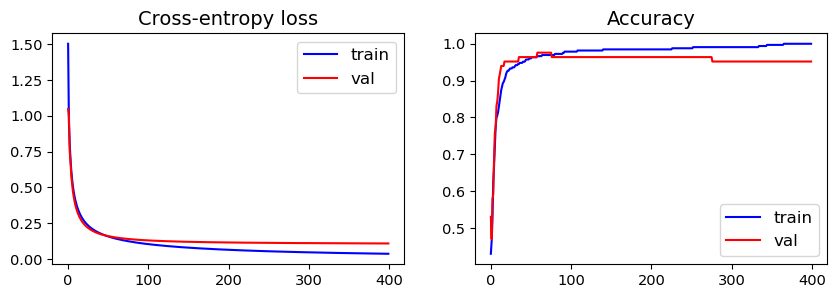

In [10]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), 
plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), 
plt.title('Accuracy')
plt.show()

#### <font color='olive'>Exercise 1 </font>

Study the behavior of the algorithm changing the number of epochs and the learning rate

In [11]:
# <Write your code here>

#### <font color='olive'>Exercise 2 </font>

Repeat the analysis for the other dataset, trying to obtain as large an accuracy value as possible. What do you believe are the reasons for the very different performance for both datasets?

In [12]:
# <Write your code here>

Linear logistic regression allowed us to review a few concepts that are key for Neural Networks:

* Network topology (In this case, a linear network with one layer)
* Activation functions
* Parametric approach ($\bf w$/$b$)
* Parameter initialization
* Obtaining the network prediction using *forward* computation
* Loss function
* Parameter gradient calculus using *backward* computation
* Optimization method for parameters update (here, GD)

### <font color='teal'> 3.2. Single-Layer Neural Networks for Multiclass Classification </font>

#### <font color='teal'> 3.2.1. Multiclass problems and one-hot encoding </font>

The single-layer NN can be easily extended to problems with $M \ge 2$ classes, $0, 1, \ldots, M-1$. 

To do so, we will represent classes using one-hot encoding, that is, $M$-dimensional vectors with zero componentes unless for a value 1 in the position indicated by the class. 

For instance, classes in $\{0, 1, 2, 3\}$ will be represented by vectors
$$
\pmatrix{1 \\ 0 \\ 0 \\ 0}, \, \,
\pmatrix{0 \\ 1 \\ 0 \\ 0}, \, \,
\pmatrix{0 \\ 0 \\ 1 \\ 0} \text{ and }
\pmatrix{0 \\ 0 \\ 0 \\ 1},
$$
respectively.

Thus, both the true-class, ${\bf y}$ and the prediction $\hat{\bf y}$ will be one-hot $M$-dimensional vectors .

#### <font color='teal'> 3.2.2. Architecture </font>

A natural extension of the single layer NN to multiple classes is shown in the figure

<center><img src="figures/SR_network.png" width="500"/></center>



The components of the multiclass model a multidimensional extensions of those of the single-layer NN:

 * A **linear combination** is computed per each class. Note that, defining the matrix ${\bf W}=({\bf w}_0| {\bf w}_1 | \cdots | {\bf w}_{M-1})^\intercal$, we can write
$$
{\bf o} = {\bf W}{\bf x} + {\bf b}
$$
 * **Activation function**. The **softmax** function is the most common choice. It is a multidimensional generalization of the logistic function (invented in 1959 by the social scientist R. Duncan Luce) and defined as
\begin{align}
q_i = \frac{\exp(o_i)}{\sum_{j=0}^{M-1} \exp(o_j)},
\end{align}
and it provides probabilistic soft predictions because
$$0 \le q_i \le 1$$ 
$$\sum_{j=0}^{M-1} q_j =1$$
The derivatives of the softmax components, that will be required for training, are given by
\begin{align}
\frac{\partial q_i}{\partial o_i} &= q_i (1 - q_i) \\
\frac{\partial q_i}{\partial o_j} &= - q_i q_j,  \qquad  j \neq i
\end{align}

* **Class prediction**: the final transformation maps the probabilistic predictions into a class prediction in one-hot form. Following the probabilistic interpretation of the soft prediction, we can use the **hardmax** function, which outputs a zero vector with a unit value in the ouput corresponding to the highest probabilistic input, that is,
$$
\hat{y}_i = 
\left[ \begin{array}{ll}
        1, & \text{ if } q_i = \max_j q_j  \\
        0, & \text{ otherwise}
\end{array} \right.
$$
The classifier is still linear, in the sense that
$$\text{hardmax}({\bf q}) = \text{hardmax}({\bf o}) = \text{hardmax}({\bf W} {\bf x} + {\bf b}\}$$


#### <font color='teal'> 3.2.3. Loss function </font>

The losses defined for the binary case can be easily extended to the multiclass setting:

The multi-class version of the cross entropy is defined as
* **Square error**: $\ell_2({\bf y}, {\bf q}) = \|{\bf y} - {\bf q}\|^2$
* **Absolute error**: $\ell_1({\bf y}, {\bf q}) = |{\bf y} - {\bf q}|$
* **Cross entropy**: $\ell_\text{CE}({\bf y}, {\bf q}) = - \sum_{j=0}^{M-1} (y_j \log(q_j) + (1-y_j) \log(1-q_j)$

We will implement the cross entropy. For evaluation purposes, the accuracy will be used

In [13]:
def accuracy(y, q):
    return np.mean(np.argmax(y, axis=1) == np.argmax(q, axis=1))

def loss(y, q):
    return - np.sum(y * np.log(q))

#### <font color='teal'> 3.2.4. Probabilistic model </font>

As in the binary case, any neural network architecture with a probabilistic activation function defines a parametric probability model. For the architecture in the figure, such model is given by
$$
P(y_i=1|{\bf x}, {\bf W}, {\bf b}) = q_i  \\
{\bf q} = \text{softmax}({\bf W}{\bf x} + {\bf b})
$$

Consequently, the negative log-likelihood is identical to the empirical risk defined by the cross entropy, that is
$$
\text{NLL}({\bf W}, {\bf b}) = \sum_{k=0}^{K-1} \ell_\text{CE}({\bf y}_k, {\bf q}_k)
$$

We will define a method to compute the softmax activation, and a ${\tt forward}$ method to compute the soft prediction from the inputs

In [14]:
# Define some useful functions
def softmax(t):
    """Compute softmax values for each sets of scores in t."""
    e_t = np.exp(t)    
    return e_t / e_t.sum(axis=1, keepdims=True)

def forward(w, b, x):
    # Compute the soft prediction of the network
    return softmax(x @ w.T + b.T)

#### <font color='teal'> 3.2.4. Training </font>

The Gradient Descent learning rules are given by
$${\bf W}_{n+1} = {\bf W}_n - \rho_n \sum_{k=0}^{K-1} \frac{\partial l({\bf y}_k,{{\bf q}_k})}{\partial {\bf W}}$$
$${\bf b}_{n+1} = {\bf b}_n - \rho_n \sum_{k=0}^{K-1} \frac{\partial l({\bf y}_k,{{\bf q}_k})}{\partial {\bf b}}$$

Applying the chain rule, and using the derivatives of the softmax function, the derivatives can be computed as follows:

\begin{align}
\frac{\partial l({\bf y}, {\bf q})}{\partial {\bf W}}
    &= \frac{\partial l({\bf y}, {\bf q})}{\partial {\bf o}} 
                 \cdot \frac{\partial {\bf o}}{\partial {\bf W}} \\ 
    &= \sum_{i=0}^{M-1}
           \frac{\partial l({\bf y}, {\bf q})}{\partial o_i} 
               \cdot \frac{\partial o_i}{\partial {\bf W}} \\ 
    &= \frac{\partial l({\bf y}, {\bf q})}{\partial {\bf o}} 
           \cdot {\bf x}^\intercal \\ 
    &= \frac{\partial {\bf q}}{\partial {\bf o}} 
           \cdot \frac{\partial l({\bf y}, {\bf q})}{\partial {\bf q}}
           \cdot {\bf x}^\intercal \\ 
    & = \left[\begin{array}{ccccc}
                  q_1 (1 - q_1) & - q_1 q_2      & \dots  & - q_1 q_{M-1} \\ 
                  - q_2 q_1      & q_2 (1 - q_2) & \dots  & - q_2 q_{M-1} \\
                  \vdots                  & \vdots                  & \ddots & \vdots                 \\
                  - q_{M-1} q_1 & -q_{M-1} q_2  & \dots  & q_{M-1} (1-q_{M-1})  
              \end{array}\right] 
        \left[\begin{array}{c} -y_1/q_1 \\ -y_2/q_2 \\ \vdots \\ - y_{M-1}/q_{M-1} \end{array}\right] 
        {\bf x}^\intercal \\
    & = ({\bf q} - {\bf y}){\bf x}^\intercal \\
\\
\frac{\partial l({\bf y},{{\bf q}})}{\partial {\bf b}} 
    & = {\bf q} - {\bf y}
\end{align}

Thus, the gradient descent learning rules are
$${\bf W}_{n+1} = {\bf W}_n - \rho_n \sum_{k=0}^{K-1} ({\bf q}_{k,n} - {\bf y}_k) \cdot {\bf x}_k^\intercal$$
$${\bf b}_{n+1} = {\bf b}_n - \rho_n \sum_{k=0}^{K-1} ({\bf q}_{k,n} - {\bf y}_k) $$
where ${\bf q}_{k,n}$ is the soft prediction for sample $k$. It depends on $n$ because the soft prediction depends on the weights, which change at each iteration.

In [15]:
def backward(y, q, x):
    #Calcula los gradientes
    W_grad = (q - y).T @ x / len(y)
    b_grad = (q - y).T.mean(axis=1, keepdims=True)
    return W_grad, b_grad

#### <font color='teal'> 3.2.5. Testing the multi-class single-layer NN </font>

Now, we will test the behavior of the multiclass NN with the digits dataset.

In [16]:
dataset = 'digits'
X_train, X_val, y_train, y_val = get_dataset('digits')

In [17]:
# Neural Network Training

epochs = 300
rho = .1

#Parameter initialization
W = .1 * np.random.randn(y_train.shape[1], X_train.shape[1])
b = .1 * np.random.randn(y_train.shape[1], 1)

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in np.arange(epochs):
    print(f"Epoch {epoch + 1} out of {epochs}   \r", end="")
    q_train = forward(W, b, X_train)
    q_val = forward(W, b, X_val)
    W_grad, b_grad = backward(y_train, q_train, X_train)
    W = W - rho * W_grad
    b = b - rho * b_grad
    
    loss_train[epoch] = loss(y_train, q_train)
    loss_val[epoch] = loss(y_val, q_val)
    acc_train[epoch] = accuracy(y_train, q_train)
    acc_val[epoch] = accuracy(y_val, q_val)
    

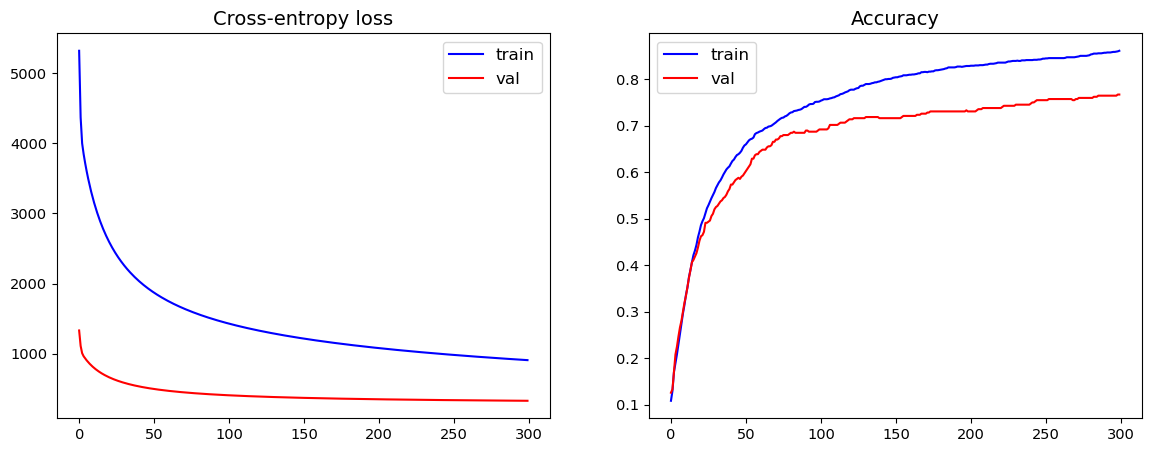

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), 
plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), 
plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

#### <font color='olive'>Exercise 3</font>

Study the behavior of the algorithm changing the number of iterations and the learning rate

In [25]:
# Write your code here

#### <font color='olive'>Exercise 4</font>

Obtain the confusion matrix, and study which classes are more difficult to classify


In [25]:
# Write your code here

#### <font color='olive'>Exercise 5</font>

Think about the differences between using this 10-class network, vs training 10 binary classifiers, one for each class

In [26]:
# Write your response here

As in linear logistic regression note that we covered the following aspects of neural network design, implementation, and training:

* Network topology (In this case, a linear network with one layer and $M$ ouptuts)
* Activation functions (softmax activation)
* Parameter initialization ($\bf W$/$b$)
* Obtaining the network prediction using *forward* computation
* Loss function
* Parameter gradient calculus using *backward* computation
* Optimization method for parameters update (here, GD)

### <font color='teal'> 3.3. Multi Layer Networks (Deep Networks) </font>

Previous networks are constrained in the sense that they can only implement linear classifiers: the boundary decision of a binary single-layer NN is linear (an hyperplane) and the boundary sepearating each pair of classes in a multi-class single-layer NN is also linear. 

As in logistic regression, we can easily appl the single-layer NN to non-linear classification problemas by using fixed non-linear transformations of the inputs: ${\bf z} = {\bf{f}}({\bf x})$, as the inputs to the linear layer. However, a fixed non-linear transformation limits the adaptability of the network to different datasets.

An interesting alternative is to parametrize the transformation using one or more non-linear layers of neurons. This is the central idea of the **multi-layer perceptron** (MLP).

<center><img src="figures/LR_MLPnetwork.png" width="600"/></center>

* When counting layers, we normally ignore the input layer, since there is no computation involved
* Intermediate layers are normally referred to as "hidden" layers
* Non-linear activations result in an overall non-linear classifier
* We can still use Gradient Descent Optimization as long as the network loss derivatives with respect to all parameters exist.
* This is already deep learning. We can have two layers or more, each with different numbers of neurons. But as long as derivatives with respect to parameters can be calculated, the network can be optimized
* Finding an appropriate number of layers for a particular problem, as well as the number of neurons per layer, requires exploration
* The more data we have for training the network, the more parameters we can afford, making feasible the use of more complex topologies

#### <font color='teal'> 3.3.1. Example: a 2-layer network for binary classification</font>

##### <font color='teal'> Network topology

The forward computation graph, shown in the figure, illustrates the computation stept that produce the network prediction and the loss computation
<center><img src="figures/forward_graph.png" width="500"/></center>

  * **Hidden layers**: one hidden layer with $n_h$ neurons with hyperbolic tangent activation. The hyperbolic tangent is just a shifted version of the logistic function producing output in the interval $[-1, 1]$ $(\text{tanh}(o) = 2 \text{logistic}(o)-1)$. It does not produce probabilistic outputs, but they are not needed at intermediate layers.

  * **Output layer**: a single neuron with logistci activation function.
  * **Loss function**: Cross-entropy


         
The network equations are, thus:

$${\bf h} = \text{tanh}({\bf o}^{(1)})= \text{tanh}\left({\bf W}^{(1)} {\bf x} + {\bf b}^{(1)}\right)$$
$$q = \text{logistic}(o) = \text{logistic}\left({{\bf w}^{(2)}}^\top {\bf h} + b^{(2)}\right)$$

(where the hyperbolic tangent of a vector is computed component-wise). They are implemented in the forward method, below.

In [42]:
# Define some useful functions
def logistic(t):
    return 1.0 / (1 + np.exp(-t))

def forward(W1, b1, w2, b2, x):
    # Calcula la salida de la red
    h = 2 * logistic(x.dot(W1.T) + b1) - 1
    q = logistic(h.dot(w2) + b2)
    # Provide also hidden units value for backward gradient step
    return h, q

##### <font color='teal'> Training

We will train the neural network by applying the gradient descent learning rule to the minimization of the NLL (i.e. the cumulative cross entropy).

  To do so, we need to compute the derivatives of the loss with respect to every network parameter. We will do it by applying extensively the chain rule:

  * **Output layer** weights: the derivatives are the same that we have computed for the single-layer NN, since the dependency of the loss on the output layer weights is the same (we just need to use ${\bf h}$ instead of ${\bf x}$):

  $${\bf w}_{n+1}^{(2)} = {\bf w}_n^{(2)} + \rho_n \sum_{k=0}^{K-1} (y_k - q_k){\bf h}_k$$
  $$b_{n+1}^{(2)} = b_n^{(2)} + \rho_n \sum_{k=0}^{K-1} (y_k - q_k)$$
  
  * **Hidden layer** weights: we need to use the chain rule (we ignore dimensions and rearrange at the end)    
\begin{align}
\\
\frac{\partial l(y, q)}{\partial {\bf W}^{(1)}} 
    & = \frac{\partial l(y, q)}{\partial o} 
            \cdot \frac{\partial o}{\partial {\bf h}} 
            \cdot \frac{\partial {\bf h}}{\partial {\bf o}^{(1)}} 
            \cdot \frac{\partial {\bf o}^{(1)}}{\partial {\bf W}^{(1)}} \\
    & = (q - y) [{\bf w}^{(2)} \odot ({\bf 1}-{\bf h})^2] {\bf x}^{\top}
\end{align}
    (Note that $\dfrac{\partial {\bf o}^{(1)}}{\partial {\bf W}^{(1)}}$ is actually a three dimensional matrix (i.e. a *tensor*). To apply the chain rule properly, the multiplications in the above equation must represent the adequate tensor products)
\begin{align}
\\
\frac{\partial l(y, q)}{\partial {\bf b}^{(1)}} 
    & = \frac{\partial l(y, q)}{\partial o} 
            \cdot \frac{\partial o}{\partial {\bf h}} 
            \cdot \frac{\partial {\bf h}}{\partial {\bf o}^{(1)}} 
            \cdot \frac{\partial {\bf o}^{(1)}}{\partial {\bf b}^{(1)}} \\
    & = (q - y) [{\bf w}^{(2)} \odot ({\bf 1}-{\bf h})^2]
\end{align}
    where $\odot$ denotes component-wise multiplication and the square after $({\bf 1}-{\bf h})$ should be computed component-wise

* GD update rules become
$${\bf W}_{n+1}^{(1)} = {\bf W}_n^{(1)} + \rho_n \sum_{k=0}^{K-1} (y_k - q_k)[{\bf w}^{(2)} \odot ({\bf 1}-{\bf h}_k)^2] {\bf x}_k^{\top}$$
$${\bf b}_{n+1}^{(1)} = {\bf b}_n^{(1)} + \rho_n \sum_{k=0}^{K-1} (y_k - q_k)[{\bf w}^{(2)} \odot ({\bf 1}-{\bf h}_k)^2]$$
  (Note that $q_k$ and ${\bf h}_k$ depend on $n$; we have omitted the dependency on $n$ to avoid a notation overload). 

In [43]:
def backward(y, y_hat, h, x, w2):
    #Calcula los gradientes
    w2_grad = h.T.dot(y_hat - y) / len(y)
    b2_grad = np.sum(y_hat - y) / len(y)
    W1_grad = ((w2[np.newaxis,] * ((1 - h)**2) * (y_hat - y)[:,np.newaxis]).T.dot(x)) / len(y)
    b1_grad = ((w2[np.newaxis,] * ((1 - h)**2) * (y_hat - y)[:,np.newaxis]).sum(axis=0)) / len(y)
    return w2_grad, b2_grad, W1_grad, b1_grad
    
def accuracy(y, y_hat):
    return np.mean(y == (y_hat >= 0.5))

def loss(y, y_hat):
    return - np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / len(y)

#### <font color='teal'> 3.3.2. The back-propagation algorithm </font>

The process that we have followed to compute the loss derivatives with respect to the weights can be extended to networks with an arbitrary number of layers.

Note that derivatives are computed backwards: from the last layer to the first hidden layer, so that we can use intermediate computations at a some layer to compute derivatives at previous layers. 

For this reason, the gradient descent method is called the **back-propagation** algorithm.

Deep Learning libraries implement automatic gradient camputation

  * We just define network topology
  * Computation of gradients is carried out automatically

#### <font color='teal'> 3.3.3. Example (cont): testing the 2-layer network</font>

Now we are ready to evaluate the two layer network

In [44]:
def evaluate_model(
    X_train, X_val, y_train, y_val, n_h=5, epochs=1000, rho=.005):
    
    W1 = .01 * np.random.randn(n_h, X_train.shape[1])
    b1 = .01 * np.random.randn(n_h)
    w2 = .01 * np.random.randn(n_h)
    b2 = .01 * np.random.randn(1)

    loss_train = np.zeros(epochs)
    loss_val = np.zeros(epochs)
    acc_train = np.zeros(epochs)
    acc_val = np.zeros(epochs)

    for epoch in np.arange(epochs):
        print(f'Current epoch: {epoch + 1}  \r', end="")    

        h, q_train = forward(W1, b1, w2, b2, X_train)
        dum, q_val = forward(W1, b1, w2, b2, X_val)
        w2_grad, b2_grad, W1_grad, b1_grad = backward(y_train, q_train, h, X_train, w2)
        W1 = W1 - rho/10 * W1_grad
        b1 = b1 - rho/10 * b1_grad
        w2 = w2 - rho * w2_grad
        b2 = b2 - rho * b2_grad

        loss_train[epoch] = loss(y_train, q_train)
        loss_val[epoch] = loss(y_val, q_val)
        acc_train[epoch] = accuracy(y_train, q_train)
        acc_val[epoch] = accuracy(y_val, q_val)

    return loss_train, loss_val, acc_train, acc_val


#### <font color='olive'>Results in Dogs vs Cats dataset ($epochs = 1000$ and $\rho = 0.05$)</font>

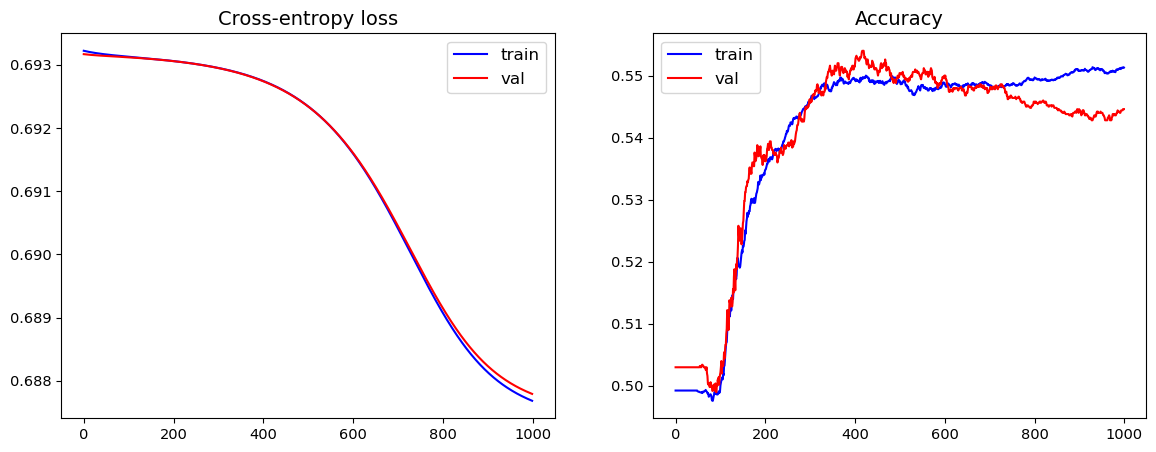

In [45]:
dataset = 'DogsCats'

X_train, X_val, y_train, y_val = get_dataset(dataset)
loss_train, loss_val, acc_train, acc_val = evaluate_model(
    X_train, X_val, y_train, y_val, n_h=5, epochs=1000, rho=0.05)

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'),
plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'),
plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

#### <font color='olive'>Results in Binary Sign Digits Dataset ($epochs = 10000$ and $\rho = 0.001$)</font>

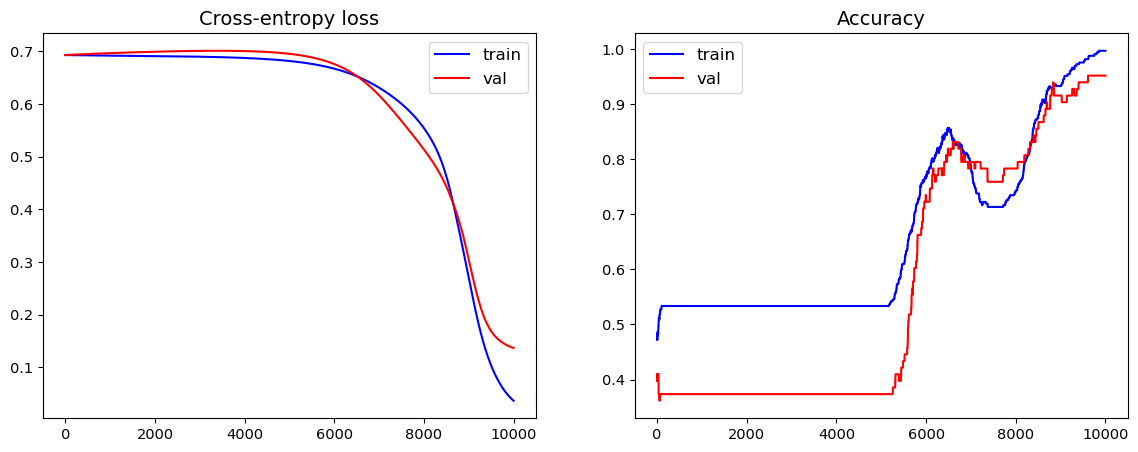

In [36]:
dataset = 'digits'
X_train, X_val, y_train, y_val = get_dataset(dataset, forze_binary=True)
loss_train, loss_val, acc_train, acc_val = evaluate_model(
    X_train, X_val, y_train, y_val, n_h=5, epochs=10000, rho=0.001)

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'),
plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'),
plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

### <font color='olive'>Exercises</font>

* Train the network using other settings for:
    * The number of iterations
    * The learning step
    * The number of neurons in the hidden layer
   
* You may find divergence issues for some settings
    * Related to the use of the hyperbolic tangent function in the hidden layer (numerical issues)
    * This is also why learning step was selected smaller for the hidden layer
    * Optimized libraries rely on certain modifications to obtain more robust implementations
    
* Try to solve both problems using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html">scikit-learn implementation</a>
    * You can also explore other activation functions
    * You can also explore other solvers to speed up convergence
    * You can also adjust the size of minibatches
    * Take a look at the *early_stopping* parameter

### <font color='teal'> 2.4. Activation Functions</font>

You can refer to the <a href="http://d2l.ai/chapter_multilayer-perceptrons/mlp.html#activation-functions">Dive into Deep Learning book</a> for a more detailed discussion on common actiation functions for the hidden units. 

We extract some information about the very important **ReLU** function

> *The most popular choice, due to both simplicity of implementation and its good performance on a variety of predictive tasks, is the rectified linear unit (ReLU). ReLU provides a very simple nonlinear transformation. Given an element $x$, the function is defined as the maximum of that element and 0.*

> *When the input is negative, the derivative of the ReLU function is 0, and when the input is positive, the derivative of the ReLU function is 1. When the input takes value precisely equal to 0, we say that the derivative is 0 when the input is 0.*

> *The reason for using ReLU is that its derivatives are particularly well behaved: either they vanish or they just let the argument through. This makes optimization better behaved and it mitigated the well-documented problem of vanishing gradients that plagued previous versions of neural networks.*

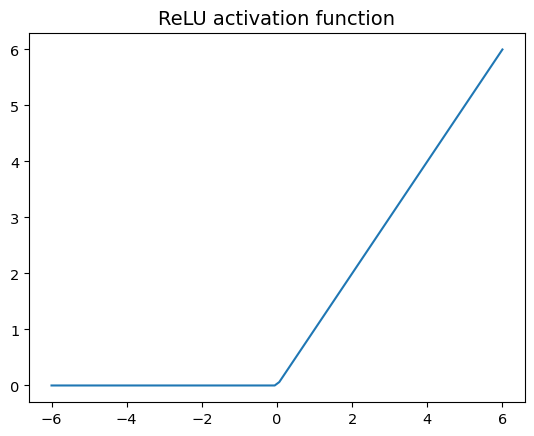

In [23]:
x_array = np.linspace(-6,6,100)
y_array = np.clip(x_array, 0, a_max=None)
plt.plot(x_array, y_array)
plt.title('ReLU activation function')
plt.show()

### <font color='teal'> 2.5. Multi Layer Networks for Regression </font>

* Deep Learning networks can be used to solve regression problems with the following common adjustments

    * Linear activation for the output unit
    
    * Square loss: 
    $$l(y, \hat y) = (y - \hat y)^2, \qquad \text{where} \qquad y, \hat y \in \Re$$

## <font color='teal'> 4. Implementing Deep Networks with PyTorch </font>

* Pytorch is a Python library that provides different levels of abstraction for implementing deep neural networks

* The main features of PyTorch are:
    * Definition of numpy-like n-dimensional *tensors*. They can be stored in / moved to GPU for parallel execution of operations
    * Automatic calculation of gradients, making *backward gradient calculation* transparent to the user
    * Definition of common loss functions, NN layers of different types, optimization methods, data loaders, etc, simplifying NN implementation and training
    * Provides different levels of abstraction, thus a good balance between flexibility and simplicity
    
* This notebook provides just a basic review of the main concepts necessary to train NNs with PyTorch taking materials from:
    * <a href="https://pytorch.org/tutorials/beginner/pytorch_with_examples.html">Learning PyTorch with Examples</a>, by Justin Johnson
    * <a href="https://pytorch.org/tutorials/beginner/nn_tutorial.html">What is *torch.nn* really?</a>, by Jeremy Howard
    * <a href="https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers">Pytorch Tutorial for Deep Learning Lovers</a>, by Kaggle user kanncaa1

### <font color='teal'> 4.1. Installation and PyTorch introduction</font>

* PyTorch can be installed with or without GPU support
    * If you have an Anaconda installation, you can install from the command line, using the <a href="https://pytorch.org/">instructions of the project website</a>
    
* PyTorch is also preinstalled in Google Collab with free GPU access
    * Follow RunTime -> Change runtime type, and select GPU for HW acceleration
    
* Please, refer to Pytorch [getting started](https://pytorch.org/get-started/locally/) tutorial for a quick introduction regarding tensor definition, GPU vs CPU storage of tensors, operations, and bridge to Numpy

### <font color='teal'> 4.2. Torch tensors (very) general overview</font>

* We can create tensors with different construction methods provided by the library, either to create new tensors from scratch or from a Numpy array

In [24]:
import torch

x = torch.rand((100,200))
digitsX_flatten_tensor = torch.from_numpy(digitsX_flatten)

print(x.type())
print(digitsX_flatten_tensor.size())

ModuleNotFoundError: No module named 'torch'

* Tensors can be converted back to numpy arrays

* Note that in this case, a tensor and its corresponding numpy array **will share memory**

* Operations and slicing use a syntax similar to numpy

In [37]:
print('Size of tensor x:', x.size())
print('Tranpose of vector has size', x.t().size()) #Transpose and compute size
print('Extracting upper left matrix of size 3 x 3:', x[:3,:3])
print(x.mm(x.t()).size())  #mm for matrix multiplications
xpx = x.add(x)
xpx2 = torch.add(x,x)
print((xpx!=xpx2).sum())   #Since all are equal, count of different terms is zero

NameError: name 'x' is not defined

* Adding underscore performs operations "*in place*", e.g., ```x.add_(y)```

* If a GPU is available, tensors can be moved to and from the GPU device

* Operations on tensors stored in a GPU will be carried out using GPU resources and will typically be highly parallelized

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    x = x.to(device)
    y = x.add(x)
    y = y.to('cpu')
else:
    print('No GPU card is available')

### <font color='teal'> 4.3. Automatic gradient calculation </font>

* PyTorch tensors have a property ```requires_grad```. When true, PyTorch automatic gradient calculation will be activated for that variable

* In order to compute these derivatives numerically, PyTorch keeps track of all operations carried out on these variables, organizing them in a forward computation graph.

* When executing the ```backward()``` method, derivatives will be calculated

* However, this should only be activated when necessary, to save computation

In [ ]:
x.requires_grad = True
y = (3 * torch.log(x)).sum()
y.backward()
print(x.grad[:2,:2])
print(3/x[:2,:2])

x.requires_grad = False
x.grad.zero_()
print('Automatic gradient calculation is deactivated, and gradients set to zero')

<font color='olive'>Exercise</font>

* Initialize a tensor ```x``` with the upper right $5 \times 10$ submatrix of flattened digits
* Compute output vector ```y``` applying a function of your choice to ```x```
* Compute scalar value ```z``` as the sum of all elements in ```y``` squared
* Check that ```x.grad``` calculation is correct using the ```backward``` method
* Try to run your cell multiple times to see if the calculation is still correct. If not, implement the necessary mnodifications so that you can run the cell multiple times, but the gradient does not change from run to run

**Note:** The backward method can only be run on scalar variables

### <font color='teal'> 4.4. Feed Forward Network using PyTorch </font>

* In this section we will change our code for a neural network to use tensors instead of numpy arrays. We will work with the sign digits datasets.

* We will introduce all concepts using a single layer perceptron (softmax regression), and then implement networks with additional hidden layers


#### <font color='olive'> 4.4.1. Using Automatic differentiation </font>

* We start by loading the data, and converting to tensors.

* As a first step, we refactor our code to use tensor operations

* We do not need to pay too much attention to particular details regarding tensor operations, since these will not be necessary when moving to higher PyTorch abstraction levels

* We do not need to implement gradient calculation. PyTorch will take care of that

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

dataset = 'digits'

#Joint normalization of all data. For images [-.5, .5] scaling is frequent
min_max_scaler = MinMaxScaler(feature_range=(-.5, .5))
X = min_max_scaler.fit_transform(digitsX_flatten)

#Generate train and validation data, shuffle
X_train, X_val, y_train, y_val = train_test_split(X, digitsY, test_size=0.2, random_state=42, shuffle=True)

#Convert to Torch tensors
X_train_torch = torch.from_numpy(X_train)
X_val_torch = torch.from_numpy(X_val)
y_train_torch = torch.from_numpy(y_train)
y_val_torch = torch.from_numpy(y_val)

In [ ]:
# Define some useful functions
def softmax(t):
    """Compute softmax values for each sets of scores in t"""
    return t.exp() / t.exp().sum(-1).unsqueeze(-1)

def model(w,b,x):
    #Calcula la salida de la red
    return softmax(x.mm(w) + b)
    
def accuracy(y, y_hat):
    return (y.argmax(axis=-1) == y_hat.argmax(axis=-1)).float().mean()

def nll(y, y_hat):
    return -(y * y_hat.log()).mean()

* Syntaxis is a bit different because input variables are tensors, not arrays

* This time we did not need to implement the backward function

In [ ]:
# Parameter initialization
W = .1 * torch.randn(X_train_torch.size()[1], y_train_torch.size()[1])
W.requires_grad_()
b = torch.zeros(y_train_torch.size()[1], requires_grad=True)

epochs = 500
rho = .5

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

In [ ]:
# Network training
for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
    
    #Compute network output and cross-entropy loss
    pred = model(W,b,X_train_torch)
    loss = nll(y_train_torch, pred)
    
    #Compute gradients
    loss.backward()
    
    #Deactivate gradient automatic updates
    with torch.no_grad():
        #Computing network performance after iteration
        loss_train[epoch] = loss.item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = model(W, b, X_val_torch)
        loss_val[epoch] = nll(y_val_torch, pred_val).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

        #Weight update
        W -= rho * W.grad
        b -= rho * b.grad
        #Reset gradients
        W.grad.zero_()
        b.grad.zero_()

It is important to deactivate gradient updates after the network has been evaluated on training data, and gradients of the loss function have been computed

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

#### <font color='olive'> 4.4.2. Using torch *nn* module </font>

* PyTorch *nn* module provides many attributes and methods that make the implementation and training of Neural Networks simpler

* ```nn.Module``` and ```nn.Parameter``` allow to implement a more concise training loop

* ```nn.Module``` is a PyTorch class that will be used to encapsulate and design a specific neural network, thus, it is central to the implementation of deep neural nets using PyTorch

* ```nn.Parameter``` allow the definition of trainable network parameters. In this way, we will simplify the implementation of the training loop.

* All parameters defined with ```nn.Parameter``` will have ```requires_grad = True```

In [ ]:
from torch import nn

class my_multiclass_net(nn.Module):
    def __init__(self, nin, nout):
        """This method initializes the network parameters
        Parameters nin and nout stand for the number of input parameters (features in X)
        and output parameters (number of classes)"""
        super().__init__()
        self.W = nn.Parameter(.1 * torch.randn(nin, nout))
        self.b = nn.Parameter(torch.zeros(nout))
        
    def forward(self, x):
        return softmax(x.mm(self.W) + self.b)
    
    def softmax(t):
        """Compute softmax values for each sets of scores in t"""
        return t.exp() / t.exp().sum(-1).unsqueeze(-1)

In [ ]:
my_net = my_multiclass_net(X_train_torch.size()[1], y_train_torch.size()[1])

epochs = 500
rho = .5

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
    
    #Compute network output and cross-entropy loss
    pred = my_net(X_train_torch)
    loss = nll(y_train_torch, pred)
    
    #Compute gradients
    loss.backward()
    
    #Deactivate gradient automatic updates
    with torch.no_grad():
        #Computing network performance after iteration
        loss_train[epoch] = loss.item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = nll(y_val_torch, pred_val).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

        #Weight update
        for p in my_net.parameters():
            p -= p.grad * rho
        #Reset gradients
        my_net.zero_grad()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

* ```nn.Module``` comes with several kinds of pre-defined layers, thus making it even simpler to implement neural networks

* We can also import the Cross Entropy Loss from ```nn.Module```. When doing so:
    - We do not have to compute the softmax, since the ```nn.CrossEntropyLoss``` already does so
    - ```nn.CrossEntropyLoss``` receives two input arguments, the first is the output of the network, and the second is the true label as a 1-D tensor (i.e., an array of integers, one-hot encoding should not be used)

In [ ]:
from torch import nn

class my_multiclass_net(nn.Module):
    def __init__(self, nin, nout):
        """Note that now, we do not even need to initialize network parameters ourselves"""
        super().__init__()
        self.lin = nn.Linear(nin, nout)
        
    def forward(self, x):
        return self.lin(x)
    
loss_func = nn.CrossEntropyLoss()

In [ ]:
my_net = my_multiclass_net(X_train_torch.size()[1], y_train_torch.size()[1])

epochs = 500
rho = .1

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
    
    #Compute network output and cross-entropy loss
    pred = my_net(X_train_torch)
    loss = loss_func(pred, y_train_torch.argmax(axis=-1))
    
    #Compute gradients
    loss.backward()
    
    #Deactivate gradient automatic updates
    with torch.no_grad():
        #Computing network performance after iteration
        loss_train[epoch] = loss.item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = loss_func(pred_val, y_val_torch.argmax(axis=-1)).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

        #Weight update
        for p in my_net.parameters():
            p -= p.grad * rho
        #Reset gradients
        my_net.zero_grad()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

Note faster convergence is observed in this case. It is actually due to a more convenient initialization of the hidden layer

#### <font color='olive'> 4.4.3. Network Optimization </font>

* We cover in this subsection two different aspects about network training using PyTorch:

    + Using ```torch.optim``` allows an easier and more interpretable encoding of neural network training, and opens the door to more sophisticated training algorithms
    
    + Using minibatches can speed up network convergence

    
* ```torch.optim``` provides two convenient methods for neural network training:
    - ```opt.step()``` updates all network parameters using current gradients
    - ```opt.zero_grad()``` resets all network parameters

In [ ]:
from torch import optim

my_net = my_multiclass_net(X_train_torch.size()[1], y_train_torch.size()[1])
opt = optim.SGD(my_net.parameters(), lr=0.1)

epochs = 500

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
    
    #Compute network output and cross-entropy loss
    pred = my_net(X_train_torch)
    loss = loss_func(pred, y_train_torch.argmax(axis=-1))
    
    #Compute gradients
    loss.backward()
    
    #Deactivate gradient automatic updates
    with torch.no_grad():
        #Computing network performance after iteration
        loss_train[epoch] = loss.item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = loss_func(pred_val, y_val_torch.argmax(axis=-1)).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

    opt.step()
    opt.zero_grad()

Note network optimization is carried out outside ```torch.no_grad()``` but network evaluation (other than forward output calculation for the training patterns) still need to deactivate gradient updates

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

### <font color='olive'> Exercise </font>

Implement network training with other optimization methods. You can refer to the <a href="https://pytorch.org/docs/stable/optim.html">official documentation</a> and select a couple of methods. You can also try to implement adaptive learning rates using ```torch.optim.lr_scheduler```

    
* Each epoch of the previous implementation of network training was actually implementing Gradient Descent

* In SGD only a *minibatch* of training patterns are used at every iteration

* In each epoch we iterate over all training patterns sequentially selecting non-overlapping *minibatches*

* Overall, convergence is usually faster than when using Gradient Descent

* Torch provides methods that simplify the implementation of this strategy

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_torch, y_train_torch)
train_dl = DataLoader(train_ds, batch_size=64)

In [ ]:
from torch import optim

my_net = my_multiclass_net(X_train_torch.size()[1], y_train_torch.size()[1])
opt = optim.SGD(my_net.parameters(), lr=0.1)

epochs = 200

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
        
    for xb, yb in train_dl:
        
        #Compute network output and cross-entropy loss for current minibatch
        pred = my_net(xb)
        loss = loss_func(pred, yb.argmax(axis=-1))
    
        #Compute gradients and optimize parameters
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    #At the end of each epoch, evaluate overall network performance
    with torch.no_grad():
        #Computing network performance after iteration
        pred = my_net(X_train_torch)
        loss_train[epoch] = loss_func(pred, y_train_torch.argmax(axis=-1)).item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = loss_func(pred_val, y_val_torch.argmax(axis=-1)).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

#### <font color='olive'> 4.4.4. Multi Layer networks using ```nn.Sequential``` </font>

* PyTorch simplifies considerably the implementation of neural network training, since we do not need to implement derivatives ourselves

* We can also make a simpler implementation of multilayer networks using ```nn.Sequential``` function

* It returns directly a network with the requested topology, including parameters **and forward evaluation method**

In [ ]:
my_net = nn.Sequential(
    nn.Linear(X_train_torch.size()[1], 200),
    nn.ReLU(),
    nn.Linear(200,50),
    nn.ReLU(),
    nn.Linear(50,20),
    nn.ReLU(),
    nn.Linear(20,y_train_torch.size()[1])
)

opt = optim.SGD(my_net.parameters(), lr=0.1)

In [ ]:
epochs = 200

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Current epoch: {epoch + 1}  \r', end="")
        
    for xb, yb in train_dl:
        
        #Compute network output and cross-entropy loss for current minibatch
        pred = my_net(xb)
        loss = loss_func(pred, yb.argmax(axis=-1))
    
        #Compute gradients and optimize parameters
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    #At the end of each epoch, evaluate overall network performance
    with torch.no_grad():
        #Computing network performance after iteration
        pred = my_net(X_train_torch)
        loss_train[epoch] = loss_func(pred, y_train_torch.argmax(axis=-1)).item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = loss_func(pred_val, y_val_torch.argmax(axis=-1)).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()

In [ ]:
print('Validation accuracy with this net:', acc_val[-1])

### <font color='teal'> 4.5. Generalization</font>

* For complex network topologies (i.e., many parameters), network training can incur in over-fitting issues

* Some common strategies to avoid this are:

    - Early stopping
    - Dropout regularization
    
<center><a href="https://medium.com/analytics-vidhya/a-simple-introduction-to-dropout-regularization-with-code-5279489dda1e"><img src="figures/dropout.png" width="450"/>Image Source</a></center>

* Data augmentation can also be used to avoid overfitting, as well as to achieve improved accuracy by providing the network some a priori expert knowledge
    - E.g., if image rotations and scalings do not affect the correct class, we could enlarge the dataset by creating artificial images with these transformations


### <font color='teal'> 4.6. Convolutional Networks for Image Processing </font>

* PyTorch implements other layers that are better suited for different applications

* In image processing, we normally recur to Convolutional Neural Networks, since they are able to capture the true spatial information of the image

<center><a href="https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html"><img src="figures/CNN.png" width="800"/>Image Source</a></center>

In [ ]:
dataset = 'digits'

#Generate train and validation data, shuffle
X_train, X_val, y_train, y_val = train_test_split(digitsX[:,np.newaxis,:,:], digitsY, test_size=0.2, random_state=42, shuffle=True)

#Convert to Torch tensors
X_train_torch = torch.from_numpy(X_train)
X_val_torch = torch.from_numpy(X_val)
y_train_torch = torch.from_numpy(y_train)
y_val_torch = torch.from_numpy(y_val)

train_ds = TensorDataset(X_train_torch, y_train_torch)
train_dl = DataLoader(train_ds, batch_size=64)

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

my_net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(my_net.parameters(), lr=0.1)

In [ ]:
epochs = 2500

loss_train = np.zeros(epochs)
loss_val = np.zeros(epochs)
acc_train = np.zeros(epochs)
acc_val = np.zeros(epochs)

for epoch in range(epochs):
    
    print(f'Número de épocas: {epoch + 1}\r', end="")
        
    for xb, yb in train_dl:
        
        #Compute network output and cross-entropy loss for current minibatch
        pred = my_net(xb)
        loss = loss_func(pred, yb.argmax(axis=-1))
    
        #Compute gradients and optimize parameters
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    #At the end of each epoch, evaluate overall network performance
    with torch.no_grad():
        # Computing network performance after iteration
        pred = my_net(X_train_torch)
        loss_train[epoch] = loss_func(pred, y_train_torch.argmax(axis=-1)).item()
        acc_train[epoch] = accuracy(y_train_torch, pred).item()
        pred_val = my_net(X_val_torch)
        loss_val[epoch] = loss_func(pred_val, y_val_torch.argmax(axis=-1)).item()
        acc_val[epoch] = accuracy(y_val_torch, pred_val).item()

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1), plt.plot(loss_train, 'b'), plt.plot(loss_val, 'r'), plt.legend(['train', 'val']), plt.title('Cross-entropy loss')
plt.subplot(1, 2, 2), plt.plot(acc_train, 'b'), plt.plot(acc_val, 'r'), plt.legend(['train', 'val']), plt.title('Accuracy')
plt.show()